In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle

import keras
from keras import backend as K
from keras import layers
from keras import models
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, Bidirectional, Flatten, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model, load_model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.initializers import Constant
from keras import regularizers

from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.utils import class_weight
import warnings

# Library for text cleaning
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import itertools

Using TensorFlow backend.


In [2]:
# Read the training data
data = pd.read_csv(r'./drugsComTrain_raw.csv')
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [3]:
# Create labels based on the original article: Grässer et al. (2018)
r = data['rating']
r_replace = r.replace({ 0 : 0, 1 : 0, 2: 0, 3: 0, 4: 0 })
r_replace = r_replace.replace({ 5 : 1, 6 : 1})
r_replace = r_replace.replace({ 7 : 2, 8 : 2, 9 : 2, 10 : 2})
# Add the label column to the data
data['label'] = r_replace
# Check the new data
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,2
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,2
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,1
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,2
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,2


2    106866
0     40075
1     14356
Name: label, dtype: int64


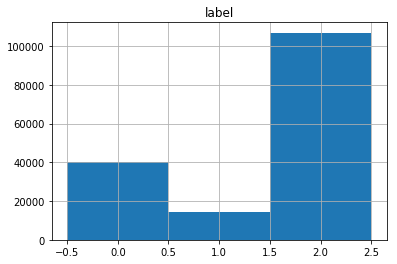

In [4]:
# Plot distribution of labels
data.hist(column = 'label', bins = np.arange(0, 4), align = 'left');
print(data['label'].value_counts())

In [5]:
length = []
for x in data['review'].values:
    length.append(len(x.split()))

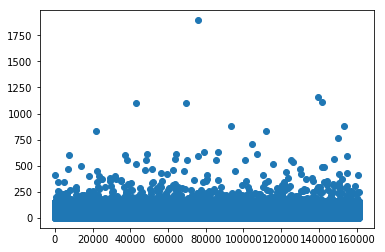

In [6]:
# Plot distribution of labels
plt.scatter(x = range(len(length)), y = length)
plt.show()

In [7]:
pd.DataFrame(length).describe()

,0
count,161297.000000
mean,84.699802
std,45.044833
min,1.000000
25%,48.000000
50%,84.000000
75%,126.000000
max,1894.000000


## Preprocessing

In [32]:
# Define Variable
seed = 24
max_len = 500 # maximum lenght of sentence
max_feature = 10000 # number of word that will be used to train
# train_size = 
validate_size = 3000
# test_size = 

batch_size = 128
epochs = 30
embedded_dim = 100

### Split train and validation dataset

In [33]:
# Group records by level feature
g = data.groupby('label')

# Sample records equal to SIZE//2 for each group for balancing the dataset
val_df = g.apply(lambda x: x.sample(validate_size//3, random_state = seed))

# Convert the labels to one_hot_category values
one_hot_labels_val = to_categorical(val_df['label'].values, num_classes = 3)

# Show distribution of datset for each class
print("How many records for each class (after balancing)")
val_df['label'].value_counts()

How many records for each class (after balancing)


1    1000
2    1000
0    1000
Name: label, dtype: int64

In [34]:
# The rest of balanced validation set is training set
train_df = data.drop(val_df.index.levels[1])

# Convert the labels to one_hot_category values
one_hot_labels_train = to_categorical(train_df['label'].values, num_classes = 3)

train_df

,uniqueID,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,2
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,2
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,2
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,0
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5,0
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32,2
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11,0
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1,2
10,29607,Topiramate,Migraine Prevention,"""I have been on this medication almost two wee...",9,1-Jan-15,19,2
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,9-Mar-17,54,2


### Compute class_weight for training process

In [42]:
class_weights = class_weight.compute_class_weight("balanced", [0,1,2], train_df['label'].values)
class_weight_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
class_weight_dict

{0: 1.3503689486031136, 1: 3.950708795048418, 2: 0.49841938551250325}

### Without preprocessing (Only basic Tokenization)

In [43]:
# Read a part of the reviews and create training sequences (x_train)
tokenizer = Tokenizer(num_words = max_feature)
tokenizer.fit_on_texts(data['review'])

X_train_normal = pad_sequences(tokenizer.texts_to_sequences(train_df['review']), maxlen = max_len)
X_val_normal = pad_sequences(tokenizer.texts_to_sequences(val_df['review']), maxlen = max_len)

In [44]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

51430

### Define  useful functions

In [45]:
# Similarly create a function for model training, for demonstration purposes we use constant values
def train_model(model, x, y, vs, cb, model_name, last_path, his_path, e = epochs, bs = batch_size, ie = 0):
    # Start timing
    start = time.time()

    # Training
    print('Training ', model_name, '...')
    h = model.fit(x, y, epochs = e, batch_size = bs, verbose = 1,
                  validation_data = vs, callbacks = cb, class_weight=class_weight_dict, initial_epoch=ie)
    
    stop = time.time()
    etime = stop - start
    print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, e, etime/e))

    # Save last model
    model.save(last_path)
    
    # Save the history
    with open(his_path, 'wb') as file_pi:
        pickle.dump(h.history, file_pi)
    return h

In [153]:
# We use the same plotting commands several times, so create a function for that purpose
def plot_history(history):
    
    baseline_model = hh
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    base_val_acc = baseline_model.history['val_acc'][:10]
    base_val_loss = baseline_model.history['val_loss'][:10]
    base_acc = baseline_model.history['acc'][:10]
    base_loss = baseline_model.history['loss'][:10]

    epochs = range(1, len(acc) + 1)
    
    # Select the first axis
    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.plot(epochs, base_acc, 'r:', label='Baseline model acc')
    plt.plot(epochs, base_val_acc, 'r--', label='Baseline model validation acc')
    plt.title('Training and validation accuracy')
    plt.ylim([0, 1])
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.plot(epochs, base_loss, 'r:', label='Baseline model loss')
    plt.plot(epochs, base_val_loss, 'r--', label='Baseline model validation loss')
    plt.title('Training and validation loss')
    plt.ylim([0, 3])
    plt.legend()

    plt.show()

## Model 1

In [125]:
del m1
K.clear_session()

m1 = Sequential()
m1.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m1.add(Dropout(0.2))
m1.add(Conv1D(64, 9, activation='relu'))
m1.add(MaxPooling1D(5))
m1.add(Conv1D(64, 9, activation='relu'))
m1.add(LSTM(16, dropout = 0.5, recurrent_dropout = 0.5))
m1.add(Dropout(0.3))
m1.add(Dense(16, activation = 'softmax'))
m1.add(Dropout(0.5))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 492, 64)           57664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 90, 64)            36928     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
__________

Training  model1 find ...
Train on 158297 samples, validate on 3000 samples
Epoch 61/90
158297/158297 [==============================] - 137s 865us/step - loss: 0.2768 - acc: 0.9109 - val_loss: 0.8381 - val_acc: 0.7907

Epoch 00061: val_loss improved from inf to 0.83809, saving model to best_find_min_loss.hdf5

Epoch 00061: val_acc improved from -inf to 0.79067, saving model to best_find_max_acc.hdf5
Epoch 62/90
158297/158297 [==============================] - 139s 881us/step - loss: 0.2759 - acc: 0.9138 - val_loss: 1.0055 - val_acc: 0.7520

Epoch 00062: val_loss did not improve from 0.83809

Epoch 00062: val_acc did not improve from 0.79067
Epoch 63/90
158297/158297 [==============================] - 139s 876us/step - loss: 0.2781 - acc: 0.9130 - val_loss: 0.7707 - val_acc: 0.8067

Epoch 00063: val_loss improved from 0.83809 to 0.77068, saving model to best_find_min_loss.hdf5

Epoch 00063: val_acc improved from 0.79067 to 0.80667, saving model to best_find_max_acc.hdf5
Epoch 64/90
158

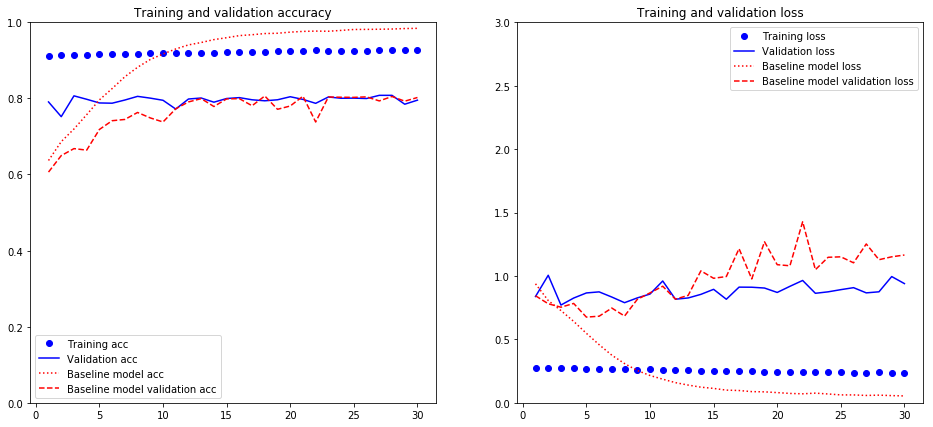

In [131]:
best_weight_find_min_loss = "best_find_min_loss.hdf5"
best_weight_find_max_acc = "best_find_max_acc.hdf5"
checkpoint_find_min_loss = ModelCheckpoint(best_weight_find_min_loss, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_find_max_acc = ModelCheckpoint(best_weight_find_max_acc, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h = train_model(m1, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val), [checkpoint_find_min_loss,checkpoint_find_max_acc],
                "model1 find", "last_find.hdf5", "20_find_his", e=90, bs=512, ie=60)
plot_history(h)

In [132]:
print("Baseline model: ")
print("val_acc: ", max(hh.history['val_acc']))
print("val_loss: ", min(hh.history['val_loss']))

print("New model: ")
print("val_acc: ", max(h.history['val_acc']))
print("val_loss: ", min(h.history['val_loss']))

Baseline model: 
val_acc:  0.8063333334922791
val_loss:  0.6755846559206645
New model: 
val_acc:  0.8080000014305114
val_loss:  0.7706802686055502


## Model 2

In [147]:
del m1
K.clear_session()

m1 = Sequential()
m1.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m1.add(Dropout(0.3))
m1.add(Conv1D(32, 11, activation='relu'))
m1.add(MaxPooling1D(5))
m1.add(Conv1D(32, 11, activation='relu'))
m1.add(LSTM(16, dropout = 0.3, recurrent_dropout = 0.3))
m1.add(Dropout(0.3))
m1.add(Dense(16, activation = 'relu'))
m1.add(Dropout(0.3))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 490, 32)           35232     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 88, 32)            11296     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
__________

Training  model1 find ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/10
158297/158297 [==============================] - 156s 984us/step - loss: 0.9815 - acc: 0.5877 - val_loss: 0.8701 - val_acc: 0.5677

Epoch 00001: val_loss improved from inf to 0.87014, saving model to best_find_min_loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.56767, saving model to best_find_max_acc.hdf5
Epoch 2/10
158297/158297 [==============================] - 117s 738us/step - loss: 0.8442 - acc: 0.6983 - val_loss: 0.8412 - val_acc: 0.6077

Epoch 00002: val_loss improved from 0.87014 to 0.84119, saving model to best_find_min_loss.hdf5

Epoch 00002: val_acc improved from 0.56767 to 0.60767, saving model to best_find_max_acc.hdf5
Epoch 3/10
158297/158297 [==============================] - 118s 744us/step - loss: 0.7858 - acc: 0.7046 - val_loss: 0.7619 - val_acc: 0.6500

Epoch 00003: val_loss improved from 0.84119 to 0.76195, saving model to best_find_min_loss.hdf5

Epoch 00003: val_acc im

ValueError: x and y must have same first dimension, but have shapes (0,) and (30,)

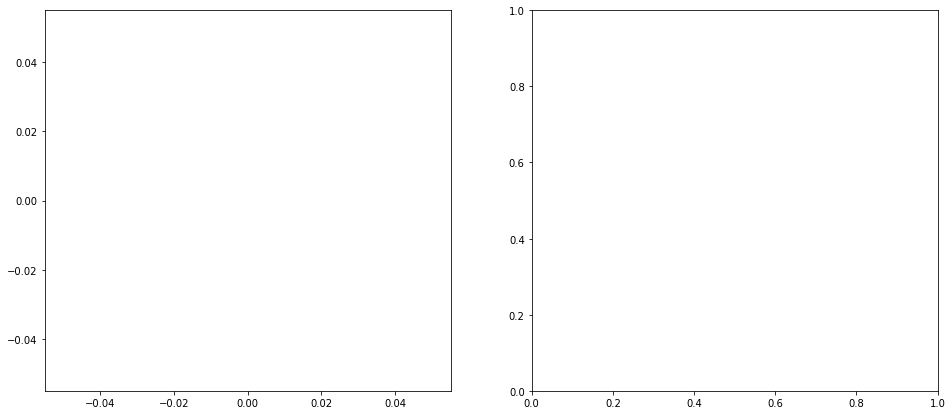

In [148]:
best_weight_find_min_loss = "best_find_min_loss.hdf5"
best_weight_find_max_acc = "best_find_max_acc.hdf5"
checkpoint_find_min_loss = ModelCheckpoint(best_weight_find_min_loss, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_find_max_acc = ModelCheckpoint(best_weight_find_max_acc, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h2 = train_model(m1, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val), [checkpoint_find_min_loss,checkpoint_find_max_acc],
                "model1 find", "last_find.hdf5", "20_find_his", e=10, bs=512)
plot_history(h2)

print("Baseline model: ")
print("val_acc: ", max(hh.history['val_acc']))
print("val_loss: ", min(hh.history['val_loss']))

print("New model: ")
print("val_acc: ", max(h.history['val_acc']))
print("val_loss: ", min(h.history['val_loss']))

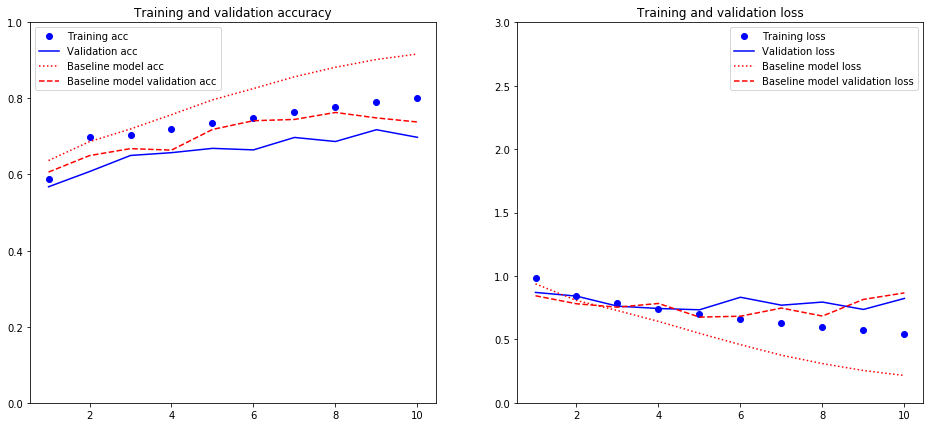

Baseline model: 
val_acc:  0.8063333334922791
val_loss:  0.6755846559206645
New model: 
val_acc:  0.7176666682561239
val_loss:  0.7332288248538971


In [154]:
plot_history(h2)

print("Baseline model: ")
print("val_acc: ", max(hh.history['val_acc']))
print("val_loss: ", min(hh.history['val_loss']))

print("New model: ")
print("val_acc: ", max(h2.history['val_acc']))
print("val_loss: ", min(h2.history['val_loss']))

## Model 3

In [136]:
del m1
K.clear_session()

m1 = Sequential()
m1.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m1.add(Dropout(0.3))
m1.add(Conv1D(32, 11, activation='relu'))
m1.add(MaxPooling1D(5))
m1.add(Conv1D(32, 11, activation='relu'))
m1.add(LSTM(16, dropout = 0.5, recurrent_dropout = 0.5))
m1.add(Dropout(0.3))
m1.add(Dense(16, activation = 'relu'))
m1.add(Dropout(0.3))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 490, 32)           35232     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 88, 32)            11296     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
__________

Training  model1 find ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/60
158297/158297 [==============================] - 160s 1ms/step - loss: 1.0274 - acc: 0.6012 - val_loss: 0.9419 - val_acc: 0.5700

Epoch 00001: val_loss improved from inf to 0.94186, saving model to best_find_min_loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.57000, saving model to best_find_max_acc.hdf5
Epoch 2/60
158297/158297 [==============================] - 121s 762us/step - loss: 0.9363 - acc: 0.6836 - val_loss: 0.8741 - val_acc: 0.6150

Epoch 00002: val_loss improved from 0.94186 to 0.87414, saving model to best_find_min_loss.hdf5

Epoch 00002: val_acc improved from 0.57000 to 0.61500, saving model to best_find_max_acc.hdf5
Epoch 3/60
158297/158297 [==============================] - 121s 762us/step - loss: 0.8861 - acc: 0.6951 - val_loss: 0.8310 - val_acc: 0.6323

Epoch 00003: val_loss improved from 0.87414 to 0.83095, saving model to best_find_min_loss.hdf5

Epoch 00003: val_acc impr

158297/158297 [==============================] - 132s 837us/step - loss: 0.4038 - acc: 0.8699 - val_loss: 0.7776 - val_acc: 0.7270

Epoch 00030: val_loss did not improve from 0.64295

Epoch 00030: val_acc did not improve from 0.77133
Epoch 31/60
158297/158297 [==============================] - 132s 836us/step - loss: 0.3953 - acc: 0.8737 - val_loss: 0.7378 - val_acc: 0.7667

Epoch 00031: val_loss did not improve from 0.64295

Epoch 00031: val_acc did not improve from 0.77133
Epoch 32/60
158297/158297 [==============================] - 133s 840us/step - loss: 0.3831 - acc: 0.8769 - val_loss: 0.6377 - val_acc: 0.7853

Epoch 00032: val_loss improved from 0.64295 to 0.63771, saving model to best_find_min_loss.hdf5

Epoch 00032: val_acc improved from 0.77133 to 0.78533, saving model to best_find_max_acc.hdf5
Epoch 33/60
158297/158297 [==============================] - 132s 836us/step - loss: 0.3821 - acc: 0.8778 - val_loss: 0.8168 - val_acc: 0.7400

Epoch 00033: val_loss did not improve fro

ValueError: x and y must have same first dimension, but have shapes (60,) and (30,)

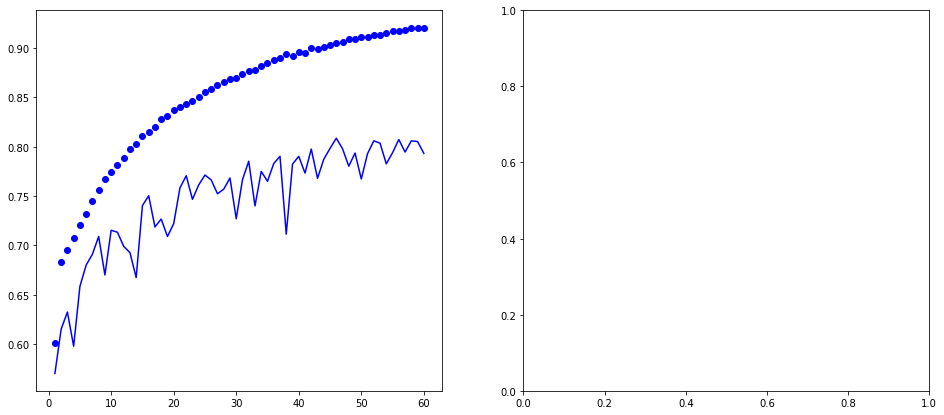

In [137]:
best_weight_find_min_loss = "best_find_min_loss.hdf5"
best_weight_find_max_acc = "best_find_max_acc.hdf5"
checkpoint_find_min_loss = ModelCheckpoint(best_weight_find_min_loss, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_find_max_acc = ModelCheckpoint(best_weight_find_max_acc, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h2 = train_model(m1, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val), [checkpoint_find_min_loss,checkpoint_find_max_acc],
                "model1 find", "last_find.hdf5", "20_find_his", e=60, bs=512)
plot_history(h2)

print("Baseline model: ")
print("val_acc: ", max(hh.history['val_acc']))
print("val_loss: ", min(hh.history['val_loss']))

print("New model: ")
print("val_acc: ", max(h.history['val_acc']))
print("val_loss: ", min(h.history['val_loss']))

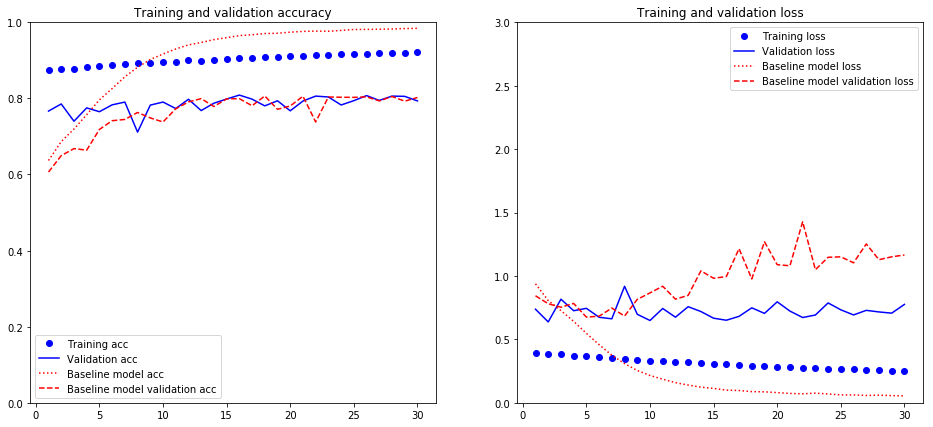

Baseline model: 
val_acc:  0.8063333334922791
val_loss:  0.6755846559206645
New model: 
val_acc:  0.8086666657129924
val_loss:  0.6377063512007396


In [146]:
plot_history(h2)

print("Baseline model: ")
print("val_acc: ", max(hh.history['val_acc']))
print("val_loss: ", min(hh.history['val_loss']))

print("New model: ")
print("val_acc: ", max(h2.history['val_acc']))
print("val_loss: ", min(h2.history['val_loss']))

## Model 4 Change output size of Conv and LSTM

In [107]:
del m1
K.clear_session()

m1 = Sequential()
m1.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m1.add(Conv1D(128, 7, activation='relu'))
m1.add(MaxPooling1D(5))
m1.add(Conv1D(128, 7, activation='relu'))
m1.add(LSTM(16, dropout = 0.5, recurrent_dropout = 0.5))
m1.add(Dropout(0.5))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 128)          89728     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 128)           114816    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total para

Training  model1 find ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/30
158297/158297 [==============================] - 187s 1ms/step - loss: 0.9578 - acc: 0.6051 - val_loss: 0.8603 - val_acc: 0.5927

Epoch 00001: val_loss improved from inf to 0.86034, saving model to best_find_min_loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.59267, saving model to best_find_max_acc.hdf5
Epoch 2/30
158297/158297 [==============================] - 159s 1ms/step - loss: 0.8241 - acc: 0.6781 - val_loss: 0.7782 - val_acc: 0.6470

Epoch 00002: val_loss improved from 0.86034 to 0.77818, saving model to best_find_min_loss.hdf5

Epoch 00002: val_acc improved from 0.59267 to 0.64700, saving model to best_find_max_acc.hdf5
Epoch 3/30
158297/158297 [==============================] - 157s 990us/step - loss: 0.7510 - acc: 0.7053 - val_loss: 0.7600 - val_acc: 0.6673

Epoch 00003: val_loss improved from 0.77818 to 0.76000, saving model to best_find_min_loss.hdf5

Epoch 00003: val_acc improv

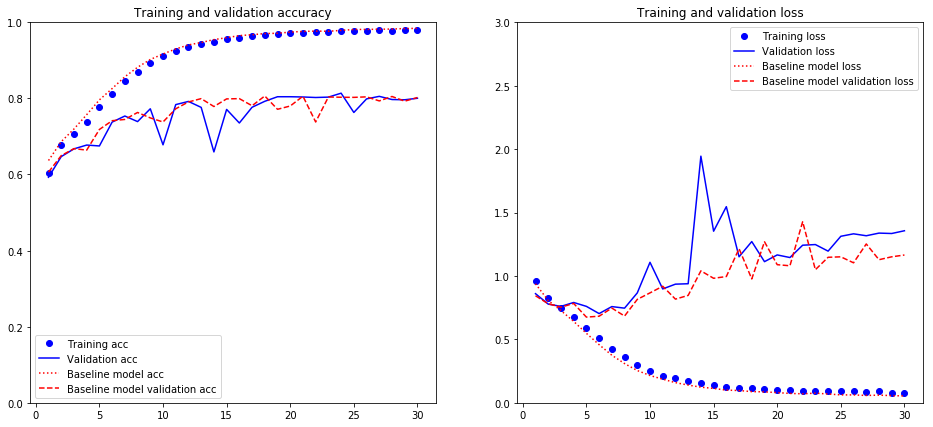

Baseline model: 
val_acc:  0.8063333334922791
val_loss:  0.6755846559206645
New model: 
val_acc:  0.8136666703224182
val_loss:  0.703433456659317


In [108]:
best_weight_find_min_loss = "best_find_min_loss.hdf5"
best_weight_find_max_acc = "best_find_max_acc.hdf5"
checkpoint_find_min_loss = ModelCheckpoint(best_weight_find_min_loss, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_find_max_acc = ModelCheckpoint(best_weight_find_max_acc, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h = train_model(m1, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val), [checkpoint_find_min_loss,checkpoint_find_max_acc],
                "model1 find", "last_find.hdf5", "20_find_his", e=30, bs=512)
plot_history(h)

print("Baseline model: ")
print("val_acc: ", max(hh.history['val_acc']))
print("val_loss: ", min(hh.history['val_loss']))

print("New model: ")
print("val_acc: ", max(h.history['val_acc']))
print("val_loss: ", min(h.history['val_loss']))

## Model 5 Change fliter size

In [109]:
del m1
K.clear_session()

m1 = Sequential()
m1.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m1.add(Conv1D(32, 3, activation='relu'))
m1.add(MaxPooling1D(5))
m1.add(Conv1D(32, 3, activation='relu'))
m1.add(LSTM(8, dropout = 0.5, recurrent_dropout = 0.5))
m1.add(Dropout(0.5))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 498, 32)           9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 97, 32)            3104      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total para

Training  model1 find ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/30
158297/158297 [==============================] - 127s 800us/step - loss: 0.9908 - acc: 0.5795 - val_loss: 0.8832 - val_acc: 0.5683

Epoch 00001: val_loss improved from inf to 0.88319, saving model to best_find_min_loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.56833, saving model to best_find_max_acc.hdf5
Epoch 2/30
158297/158297 [==============================] - 91s 578us/step - loss: 0.8842 - acc: 0.6533 - val_loss: 0.8278 - val_acc: 0.6147

Epoch 00002: val_loss improved from 0.88319 to 0.82781, saving model to best_find_min_loss.hdf5

Epoch 00002: val_acc improved from 0.56833 to 0.61467, saving model to best_find_max_acc.hdf5
Epoch 3/30
158297/158297 [==============================] - 92s 579us/step - loss: 0.8245 - acc: 0.6770 - val_loss: 0.8110 - val_acc: 0.6367

Epoch 00003: val_loss improved from 0.82781 to 0.81100, saving model to best_find_min_loss.hdf5

Epoch 00003: val_acc impr

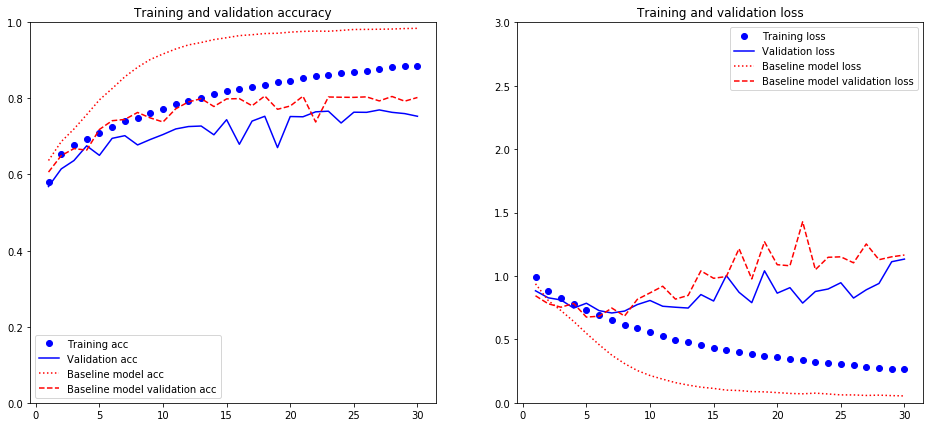

Baseline model: 
val_acc:  0.8063333334922791
val_loss:  0.6755846559206645
New model: 
val_acc:  0.7696666707992553
val_loss:  0.7080789437294006


In [110]:
best_weight_find_min_loss = "best_find_min_loss.hdf5"
best_weight_find_max_acc = "best_find_max_acc.hdf5"
checkpoint_find_min_loss = ModelCheckpoint(best_weight_find_min_loss, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_find_max_acc = ModelCheckpoint(best_weight_find_max_acc, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h = train_model(m1, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val), [checkpoint_find_min_loss,checkpoint_find_max_acc],
                "model1 find", "last_find.hdf5", "20_find_his", e=30, bs=512)
plot_history(h)

print("Baseline model: ")
print("val_acc: ", max(hh.history['val_acc']))
print("val_loss: ", min(hh.history['val_loss']))

print("New model: ")
print("val_acc: ", max(h.history['val_acc']))
print("val_loss: ", min(h.history['val_loss']))

## Model 6 LSTM -> GRU

In [111]:
del m1
K.clear_session()

m1 = Sequential()
m1.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(MaxPooling1D(5))
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(GRU(8, dropout = 0.5, recurrent_dropout = 0.5))
m1.add(Dropout(0.5))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 984       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total para

Training  model1 find ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/30
158297/158297 [==============================] - 123s 776us/step - loss: 0.9963 - acc: 0.5689 - val_loss: 0.8907 - val_acc: 0.5680

Epoch 00001: val_loss improved from inf to 0.89068, saving model to best_find_min_loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.56800, saving model to best_find_max_acc.hdf5
Epoch 2/30
158297/158297 [==============================] - 87s 549us/step - loss: 0.8950 - acc: 0.6573 - val_loss: 0.8362 - val_acc: 0.5920

Epoch 00002: val_loss improved from 0.89068 to 0.83619, saving model to best_find_min_loss.hdf5

Epoch 00002: val_acc improved from 0.56800 to 0.59200, saving model to best_find_max_acc.hdf5
Epoch 3/30
158297/158297 [==============================] - 87s 549us/step - loss: 0.8278 - acc: 0.6740 - val_loss: 0.8916 - val_acc: 0.5497

Epoch 00003: val_loss did not improve from 0.83619

Epoch 00003: val_acc did not improve from 0.59200
Epoch 4/30
158297/15

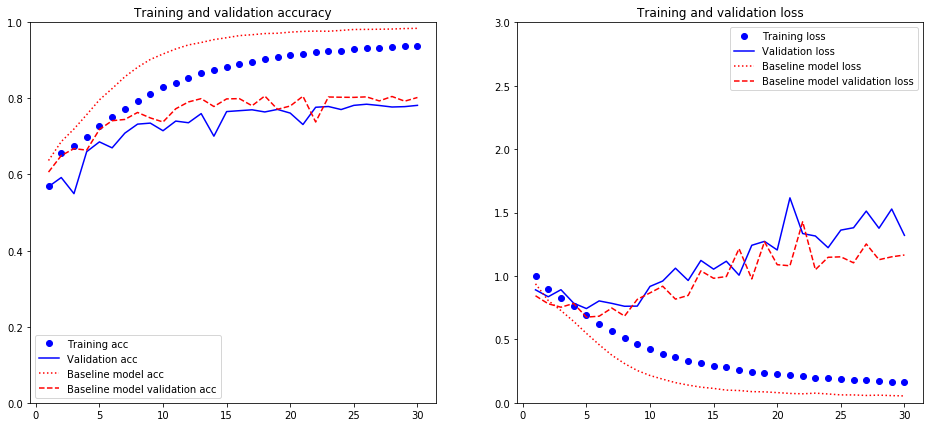

Baseline model: 
val_acc:  0.8063333334922791
val_loss:  0.6755846559206645
New model: 
val_acc:  0.7846666682561239
val_loss:  0.742962890625


In [112]:
best_weight_find_min_loss = "best_find_min_loss.hdf5"
best_weight_find_max_acc = "best_find_max_acc.hdf5"
checkpoint_find_min_loss = ModelCheckpoint(best_weight_find_min_loss, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_find_max_acc = ModelCheckpoint(best_weight_find_max_acc, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h = train_model(m1, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val), [checkpoint_find_min_loss,checkpoint_find_max_acc],
                "model1 find", "last_find.hdf5", "20_find_his", e=30, bs=512)
plot_history(h)

print("Baseline model: ")
print("val_acc: ", max(hh.history['val_acc']))
print("val_loss: ", min(hh.history['val_loss']))

print("New model: ")
print("val_acc: ", max(h.history['val_acc']))
print("val_loss: ", min(h.history['val_loss']))

## Model 7 Add regularization function

In [113]:
del m1
K.clear_session()

m1 = Sequential()
m1.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m1.add(Conv1D(32, 7, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
m1.add(MaxPooling1D(5))
m1.add(Conv1D(32, 7, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
m1.add(LSTM(8, dropout = 0.5, recurrent_dropout = 0.5))
m1.add(Dropout(0.5))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total para

Training  model1 find ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/30
158297/158297 [==============================] - 132s 834us/step - loss: 1.0449 - acc: 0.5208 - val_loss: 0.9112 - val_acc: 0.5620

Epoch 00001: val_loss improved from inf to 0.91123, saving model to best_find_min_loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.56200, saving model to best_find_max_acc.hdf5
Epoch 2/30
158297/158297 [==============================] - 97s 610us/step - loss: 0.9244 - acc: 0.6412 - val_loss: 0.8849 - val_acc: 0.5897

Epoch 00002: val_loss improved from 0.91123 to 0.88486, saving model to best_find_min_loss.hdf5

Epoch 00002: val_acc improved from 0.56200 to 0.58967, saving model to best_find_max_acc.hdf5
Epoch 3/30
158297/158297 [==============================] - 96s 608us/step - loss: 0.8777 - acc: 0.6504 - val_loss: 0.8494 - val_acc: 0.6243

Epoch 00003: val_loss improved from 0.88486 to 0.84937, saving model to best_find_min_loss.hdf5

Epoch 00003: val_acc impr

158297/158297 [==============================] - 96s 609us/step - loss: 0.3195 - acc: 0.8970 - val_loss: 1.3107 - val_acc: 0.7663

Epoch 00030: val_loss did not improve from 0.77239

Epoch 00030: val_acc did not improve from 0.77700
Done. Elapsed time 2985 seconds for 30 epochs, average 99.5 seconds/epoch.


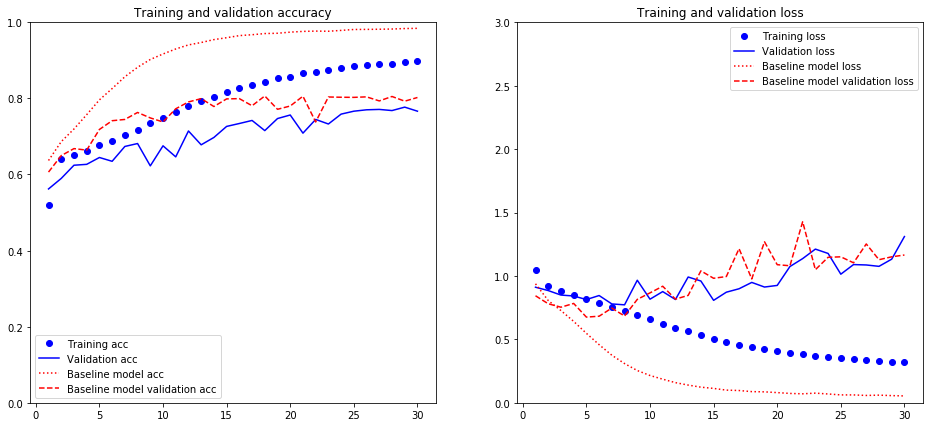

Baseline model: 
val_acc:  0.8063333334922791
val_loss:  0.6755846559206645
New model: 
val_acc:  0.7770000009536743
val_loss:  0.7723872788747151


In [114]:
best_weight_find_min_loss = "best_find_min_loss.hdf5"
best_weight_find_max_acc = "best_find_max_acc.hdf5"
checkpoint_find_min_loss = ModelCheckpoint(best_weight_find_min_loss, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_find_max_acc = ModelCheckpoint(best_weight_find_max_acc, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h = train_model(m1, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val), [checkpoint_find_min_loss,checkpoint_find_max_acc],
                "model1 find", "last_find.hdf5", "20_find_his", e=30, bs=512)
plot_history(h)

print("Baseline model: ")
print("val_acc: ", max(hh.history['val_acc']))
print("val_loss: ", min(hh.history['val_loss']))

print("New model: ")
print("val_acc: ", max(h.history['val_acc']))
print("val_loss: ", min(h.history['val_loss']))

## Model 8 Add dense layer and change output size of LSTM

In [115]:
del m1
K.clear_session()

m1 = Sequential()
m1.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(MaxPooling1D(5))
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(LSTM(32, dropout = 0.5, recurrent_dropout = 0.5))
m1.add(Dropout(0.5))
m1.add(Dense(56, activation = 'softmax'))
m1.add(Dropout(0.3))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 56)                1848      
__________

Training  model1 find ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/30
158297/158297 [==============================] - 132s 832us/step - loss: 1.0798 - acc: 0.3291 - val_loss: 1.0310 - val_acc: 0.4523

Epoch 00001: val_loss improved from inf to 1.03099, saving model to best_find_min_loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.45233, saving model to best_find_max_acc.hdf5
Epoch 2/30
158297/158297 [==============================] - 96s 609us/step - loss: 0.9923 - acc: 0.5982 - val_loss: 0.9649 - val_acc: 0.5397

Epoch 00002: val_loss improved from 1.03099 to 0.96492, saving model to best_find_min_loss.hdf5

Epoch 00002: val_acc improved from 0.45233 to 0.53967, saving model to best_find_max_acc.hdf5
Epoch 3/30
158297/158297 [==============================] - 96s 608us/step - loss: 0.9295 - acc: 0.6783 - val_loss: 0.9061 - val_acc: 0.5793

Epoch 00003: val_loss improved from 0.96492 to 0.90615, saving model to best_find_min_loss.hdf5

Epoch 00003: val_acc impr

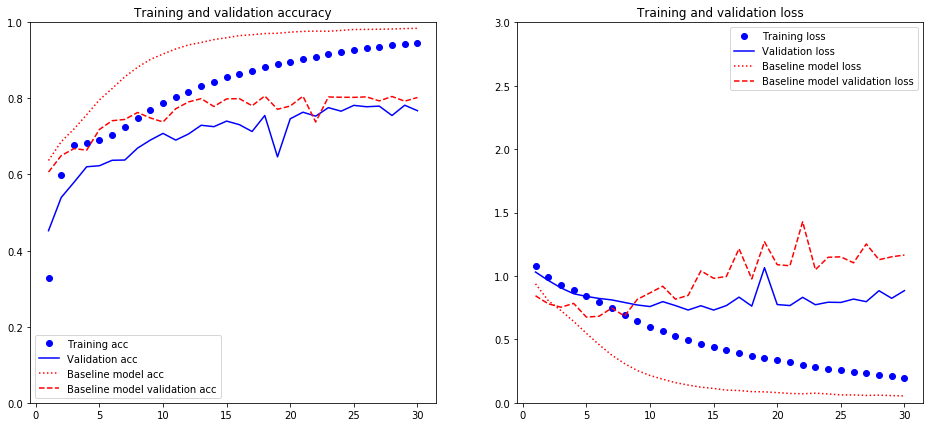

Baseline model: 
val_acc:  0.8063333334922791
val_loss:  0.6755846559206645
New model: 
val_acc:  0.7819999974568684
val_loss:  0.7311914045810699


In [116]:
best_weight_find_min_loss = "best_find_min_loss.hdf5"
best_weight_find_max_acc = "best_find_max_acc.hdf5"
checkpoint_find_min_loss = ModelCheckpoint(best_weight_find_min_loss, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_find_max_acc = ModelCheckpoint(best_weight_find_max_acc, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h = train_model(m1, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val), [checkpoint_find_min_loss,checkpoint_find_max_acc],
                "model1 find", "last_find.hdf5", "20_find_his", e=30, bs=512)
plot_history(h)

print("Baseline model: ")
print("val_acc: ", max(hh.history['val_acc']))
print("val_loss: ", min(hh.history['val_loss']))

print("New model: ")
print("val_acc: ", max(h.history['val_acc']))
print("val_loss: ", min(h.history['val_loss']))

## Model 9 Add CNN Layers

In [117]:
del m1
K.clear_session()

m1 = Sequential()
m1.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(MaxPooling1D())
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(MaxPooling1D())
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(GRU(8, dropout = 0.5, recurrent_dropout = 0.5))
m1.add(Dropout(0.5))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 247, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 241, 32)           7200      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 120, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 114, 32)           7200      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 984       
__________

Training  model1 find ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/30
158297/158297 [==============================] - 142s 896us/step - loss: 0.9988 - acc: 0.5821 - val_loss: 0.8980 - val_acc: 0.5570

Epoch 00001: val_loss improved from inf to 0.89801, saving model to best_find_min_loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.55700, saving model to best_find_max_acc.hdf5
Epoch 2/30
158297/158297 [==============================] - 105s 665us/step - loss: 0.8857 - acc: 0.6568 - val_loss: 0.8160 - val_acc: 0.6267

Epoch 00002: val_loss improved from 0.89801 to 0.81604, saving model to best_find_min_loss.hdf5

Epoch 00002: val_acc improved from 0.55700 to 0.62667, saving model to best_find_max_acc.hdf5
Epoch 3/30
158297/158297 [==============================] - 105s 664us/step - loss: 0.8198 - acc: 0.6735 - val_loss: 0.8103 - val_acc: 0.6253

Epoch 00003: val_loss improved from 0.81604 to 0.81035, saving model to best_find_min_loss.hdf5

Epoch 00003: val_acc di

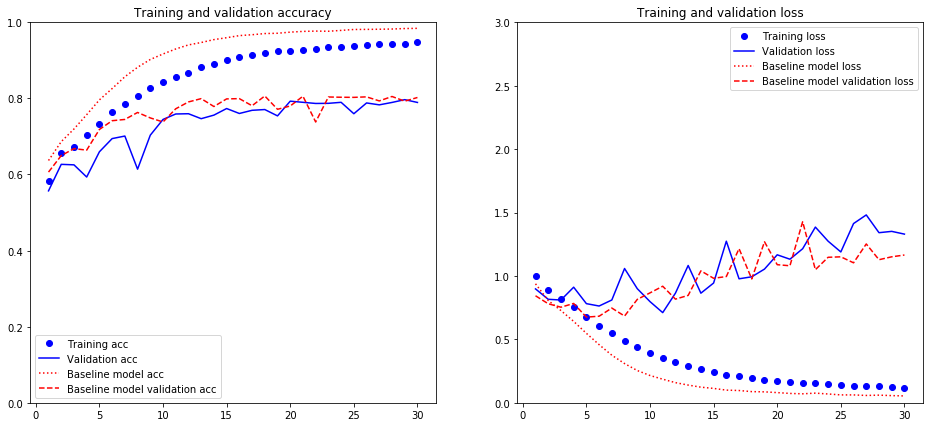

Baseline model: 
val_acc:  0.8063333334922791
val_loss:  0.6755846559206645
New model: 
val_acc:  0.7966666684150696
val_loss:  0.7109438517093658


In [118]:
best_weight_find_min_loss = "best_find_min_loss.hdf5"
best_weight_find_max_acc = "best_find_max_acc.hdf5"
checkpoint_find_min_loss = ModelCheckpoint(best_weight_find_min_loss, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_find_max_acc = ModelCheckpoint(best_weight_find_max_acc, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h = train_model(m1, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val), [checkpoint_find_min_loss,checkpoint_find_max_acc],
                "model1 find", "last_find.hdf5", "20_find_his", e=30, bs=512)
plot_history(h)

print("Baseline model: ")
print("val_acc: ", max(hh.history['val_acc']))
print("val_loss: ", min(hh.history['val_loss']))

print("New model: ")
print("val_acc: ", max(h.history['val_acc']))
print("val_loss: ", min(h.history['val_loss']))

## Model 10 Change optimizer

In [119]:
del m1
K.clear_session()

m1 = Sequential()
m1.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(MaxPooling1D(5))
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(LSTM(8, dropout = 0.5, recurrent_dropout = 0.5))
m1.add(Dropout(0.5))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total para

Training  model1 find ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/30
158297/158297 [==============================] - 133s 838us/step - loss: 1.0138 - acc: 0.5014 - val_loss: 0.8837 - val_acc: 0.5737

Epoch 00001: val_loss improved from inf to 0.88367, saving model to best_find_min_loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.57367, saving model to best_find_max_acc.hdf5
Epoch 2/30
158297/158297 [==============================] - 97s 612us/step - loss: 0.8634 - acc: 0.6420 - val_loss: 0.8016 - val_acc: 0.6417

Epoch 00002: val_loss improved from 0.88367 to 0.80162, saving model to best_find_min_loss.hdf5

Epoch 00002: val_acc improved from 0.57367 to 0.64167, saving model to best_find_max_acc.hdf5
Epoch 3/30
158297/158297 [==============================] - 97s 611us/step - loss: 0.7652 - acc: 0.6861 - val_loss: 0.7572 - val_acc: 0.6760

Epoch 00003: val_loss improved from 0.80162 to 0.75719, saving model to best_find_min_loss.hdf5

Epoch 00003: val_acc impr


Epoch 00030: val_loss did not improve from 0.71086

Epoch 00030: val_acc did not improve from 0.79667
Done. Elapsed time 2999 seconds for 30 epochs, average 100.0 seconds/epoch.


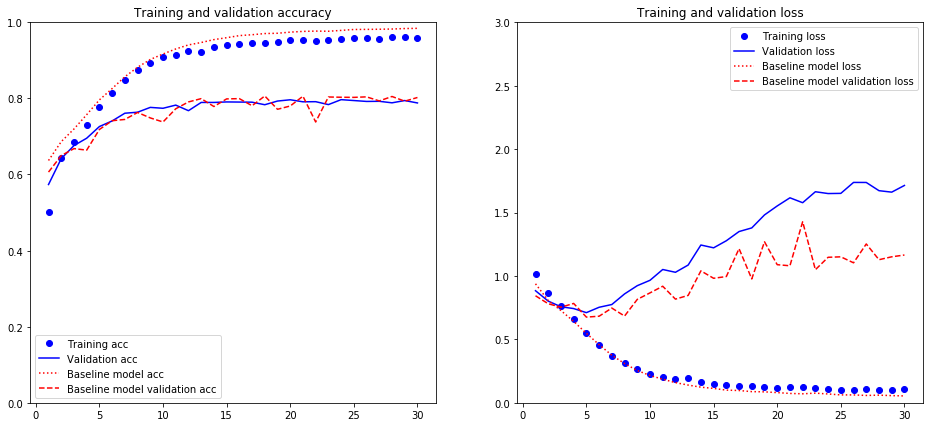

Baseline model: 
val_acc:  0.8063333334922791
val_loss:  0.6755846559206645
New model: 
val_acc:  0.7966666680971781
val_loss:  0.7108635555903117


In [120]:
best_weight_find_min_loss = "best_find_min_loss.hdf5"
best_weight_find_max_acc = "best_find_max_acc.hdf5"
checkpoint_find_min_loss = ModelCheckpoint(best_weight_find_min_loss, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_find_max_acc = ModelCheckpoint(best_weight_find_max_acc, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h = train_model(m1, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val), [checkpoint_find_min_loss,checkpoint_find_max_acc],
                "model1 find", "last_find.hdf5", "20_find_his", e=30, bs=512)
plot_history(h)

print("Baseline model: ")
print("val_acc: ", max(hh.history['val_acc']))
print("val_loss: ", min(hh.history['val_loss']))

print("New model: ")
print("val_acc: ", max(h.history['val_acc']))
print("val_loss: ", min(h.history['val_loss']))

## Model 11 Only basic model

In [121]:
del m1
K.clear_session()

m1 = Sequential()
m1.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m1.add(GRU(16, dropout = 0.2, recurrent_dropout = 0.2))
m1.add(Dropout(0.3))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                5616      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 1,005,667
Trainable params: 1,005,667
Non-trainable params: 0
_________________________________________________________________


Training  model1 find ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/30
158297/158297 [==============================] - 355s 2ms/step - loss: 0.9755 - acc: 0.6250 - val_loss: 0.9178 - val_acc: 0.5470

Epoch 00001: val_loss improved from inf to 0.91783, saving model to best_find_min_loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.54700, saving model to best_find_max_acc.hdf5
Epoch 2/30
158297/158297 [==============================] - 312s 2ms/step - loss: 0.8927 - acc: 0.6520 - val_loss: 0.8796 - val_acc: 0.5743

Epoch 00002: val_loss improved from 0.91783 to 0.87957, saving model to best_find_min_loss.hdf5

Epoch 00002: val_acc improved from 0.54700 to 0.57433, saving model to best_find_max_acc.hdf5
Epoch 3/30
158297/158297 [==============================] - 317s 2ms/step - loss: 0.8526 - acc: 0.6565 - val_loss: 0.8484 - val_acc: 0.5930

Epoch 00003: val_loss improved from 0.87957 to 0.84835, saving model to best_find_min_loss.hdf5

Epoch 00003: val_acc improved

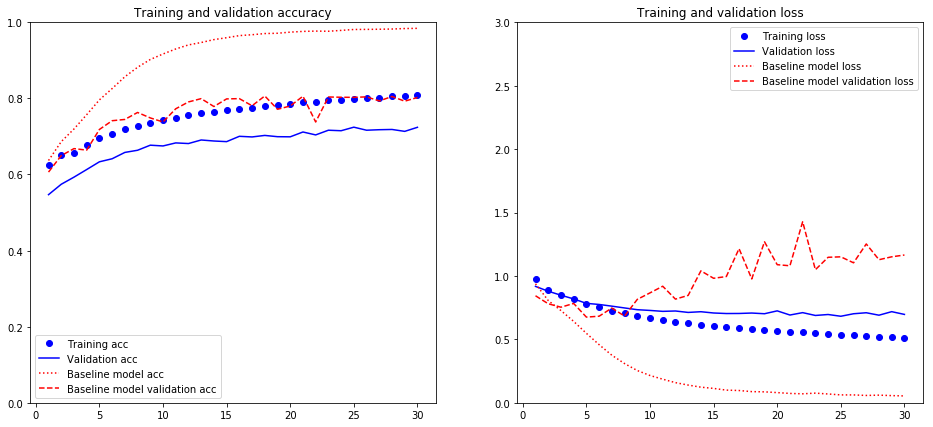

Baseline model: 
val_acc:  0.8063333334922791
val_loss:  0.6755846559206645
New model: 
val_acc:  0.7243333347638448
val_loss:  0.682319495677948


In [122]:
best_weight_find_min_loss = "best_find_min_loss.hdf5"
best_weight_find_max_acc = "best_find_max_acc.hdf5"
checkpoint_find_min_loss = ModelCheckpoint(best_weight_find_min_loss, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
checkpoint_find_max_acc = ModelCheckpoint(best_weight_find_max_acc, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

# Train the first model and plot the history (normal)
h = train_model(m1, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val), [checkpoint_find_min_loss,checkpoint_find_max_acc],
                "model1 find", "last_find.hdf5", "20_find_his", e=30, bs=512)
plot_history(h)

print("Baseline model: ")
print("val_acc: ", max(hh.history['val_acc']))
print("val_loss: ", min(hh.history['val_loss']))

print("New model: ")
print("val_acc: ", max(h.history['val_acc']))
print("val_loss: ", min(h.history['val_loss']))

## Model 12

In [37]:
m1 = Sequential()
m1.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(MaxPooling1D(5))
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(LSTM(8, dropout = 0.3, recurrent_dropout = 0.5))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 1,317,243
Trainable params: 1,317,243
Non-trainable params: 0
_________________________________________________________________


Training  model1 normal dataset ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/30
158297/158297 [==============================] - 174s 1ms/step - loss: 0.9238 - acc: 0.6170 - val_loss: 0.8255 - val_acc: 0.6210

Epoch 00001: val_loss improved from inf to 0.82550, saving model to best_normal.hdf5
Epoch 2/30
158297/158297 [==============================] - 169s 1ms/step - loss: 0.7887 - acc: 0.6887 - val_loss: 0.7684 - val_acc: 0.6583

Epoch 00002: val_loss improved from 0.82550 to 0.76838, saving model to best_normal.hdf5
Epoch 3/30
158297/158297 [==============================] - 177s 1ms/step - loss: 0.6921 - acc: 0.7327 - val_loss: 0.7757 - val_acc: 0.6593

Epoch 00003: val_loss did not improve from 0.76838
Epoch 4/30
158297/158297 [==============================] - 170s 1ms/step - loss: 0.5846 - acc: 0.7828 - val_loss: 0.7813 - val_acc: 0.6737

Epoch 00004: val_loss did not improve from 0.76838
Epoch 5/30
158297/158297 [==============================] - 183s 1ms/step 

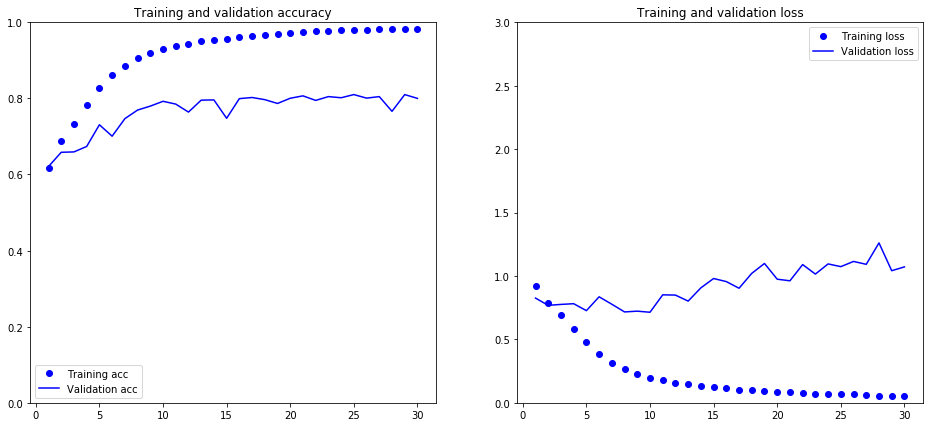

In [38]:
best_weight_normal = "best_normal.hdf5"
checkpoint_normal = ModelCheckpoint(best_weight_normal, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

# Train the first model and plot the history (normal)
h0 = train_model(m1, X_train_normal, one_hot_labels_train, (X_val_normal,one_hot_labels_val), [checkpoint_normal],
                "model1 normal dataset", "last_normal.hdf5", "20_normal_his")
plot_history(h0)

## Model 13

In [39]:
del m1
K.clear_session()

m1 = Sequential()
m1.add(Embedding(max_feature, embedded_dim, input_length = max_len))
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(MaxPooling1D(5))
m1.add(Conv1D(32, 7, activation='relu'))
m1.add(LSTM(8, dropout = 0.3, recurrent_dropout = 0.5))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 1,317,243
Trainable params: 1,317,243
Non-trainable params: 0
_________________________________________________________________


Training  model1 preprocessed dataset ...
Train on 158297 samples, validate on 3000 samples
Epoch 1/30
158297/158297 [==============================] - 171s 1ms/step - loss: 0.9118 - acc: 0.6234 - val_loss: 0.8340 - val_acc: 0.6157

Epoch 00001: val_loss improved from inf to 0.83400, saving model to best_pre.hdf5
Epoch 2/30
158297/158297 [==============================] - 168s 1ms/step - loss: 0.7788 - acc: 0.6950 - val_loss: 0.8214 - val_acc: 0.6223

Epoch 00002: val_loss improved from 0.83400 to 0.82138, saving model to best_pre.hdf5
Epoch 3/30
158297/158297 [==============================] - 168s 1ms/step - loss: 0.6854 - acc: 0.7349 - val_loss: 0.7823 - val_acc: 0.6490

Epoch 00003: val_loss improved from 0.82138 to 0.78230, saving model to best_pre.hdf5
Epoch 4/30
158297/158297 [==============================] - 170s 1ms/step - loss: 0.5761 - acc: 0.7808 - val_loss: 0.7874 - val_acc: 0.6543

Epoch 00004: val_loss did not improve from 0.78230
Epoch 5/30
158297/158297 [=============

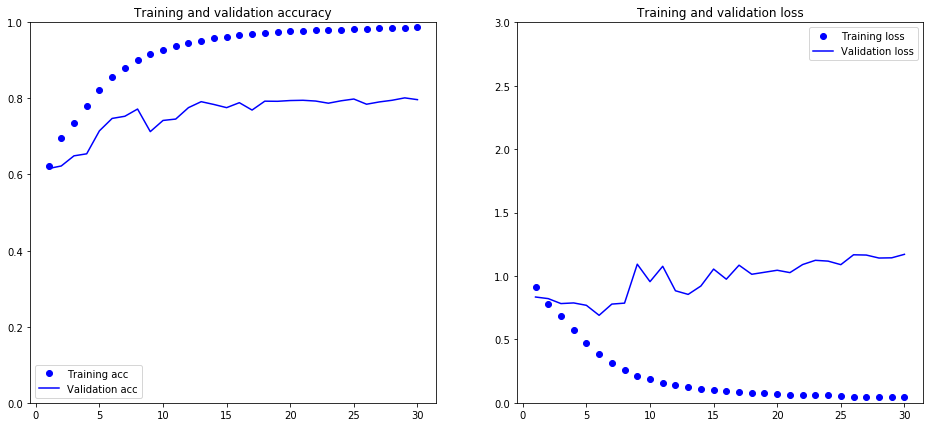

In [40]:
best_weight_pre = "best_pre.hdf5"
checkpoint_pre = ModelCheckpoint(best_weight_pre, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

# Train the first model and plot the history (normal)
h1 = train_model(m1, X_train_pre, one_hot_labels_train, (X_val_pre,one_hot_labels_val), [checkpoint_pre],
                "model1 preprocessed dataset", "last_pre.hdf5", "20_pre_his")
plot_history(h1)